# 🖥️ Projet Machine Learning Partie 1 : Classification des Laptops
**Module :** Machine Learning (M1 IA)
**Objectif :** Prédire la catégorie d'un ordinateur (Ultrabook, Gaming, etc.) en fonction de ses caractéristiques techniques.

---

### 📋 Cycle de Vie du Projet
Nous allons suivre rigoureusement les 8 étapes du cycle de vie d'un projet ML :
1.  **Compréhension du problème :** Classification Multiclasse Supervisée.
2.  **Collecte de données :** Chargement du dataset [`laptop_prices.csv`](https://www.kaggle.com/datasets/owm4096/laptop-prices/data) (Source : Kaggle).
3.  **Exploration (EDA) :** Analyse des corrélations et distributions.
4.  **Prétraitement :** Nettoyage, Imputation, Encodage, Feature Engineering.
5.  **Séparation :** Train / Test Split.
6.  **Modélisation :** Comparaison de modèles (KNN vs Random Forest).
7.  **Évaluation :** Matrice de confusion et Accuracy.
8.  **Déploiement :** Sauvegarde du modèle pour l'application Web.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE 

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [17]:
df = pd.read_csv('../data/laptop_prices.csv')

display(df.head())

print(df.info())

,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,ScreenH,Touchscreen,IPSpanel,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
0,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,1600,No,Yes,Yes,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640
1,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,900,No,No,No,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000
2,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,1080,No,No,No,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620
3,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,Standard,2880,1800,No,Yes,Yes,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455
4,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,Standard,2560,1600,No,Yes,Yes,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1275 non-null   object 
 1   Product               1275 non-null   object 
 2   TypeName              1275 non-null   object 
 3   Inches                1275 non-null   float64
 4   Ram                   1275 non-null   int64  
 5   OS                    1275 non-null   object 
 6   Weight                1275 non-null   float64
 7   Price_euros           1275 non-null   float64
 8   Screen                1275 non-null   object 
 9   ScreenW               1275 non-null   int64  
 10  ScreenH               1275 non-null   int64  
 11  Touchscreen           1275 non-null   object 
 12  IPSpanel              1275 non-null   object 
 13  RetinaDisplay         1275 non-null   object 
 14  CPU_company           1275 non-null   object 
 15  CPU_freq             

In [18]:
df['Ram'] = df['Ram'].astype(str).str.replace('GB', '').astype(int)
df['Weight'] = df['Weight'].astype(str).str.replace('kg', '').astype(float)

print(df[['Ram', 'Weight']].dtypes)

Ram         int64
Weight    float64
dtype: object


In [19]:
# Création de la variable PPI (Pixels Per Inch)
df['PPI'] = np.sqrt(df['ScreenW']**2 + df['ScreenH']**2) / df['Inches']

df_classif = df.drop(columns=['Inches', 'ScreenW', 'ScreenH', 'Product', 'Price_euros', 'Screen'])

display(df_classif.head(3))

,Company,TypeName,Ram,OS,Weight,Touchscreen,IPSpanel,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model,PPI
0,Apple,Ultrabook,8,macOS,1.37,No,Yes,Yes,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640,226.983005
1,Apple,Ultrabook,8,macOS,1.34,No,No,No,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000,127.677940
2,HP,Notebook,8,No OS,1.86,No,No,No,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620,141.211998


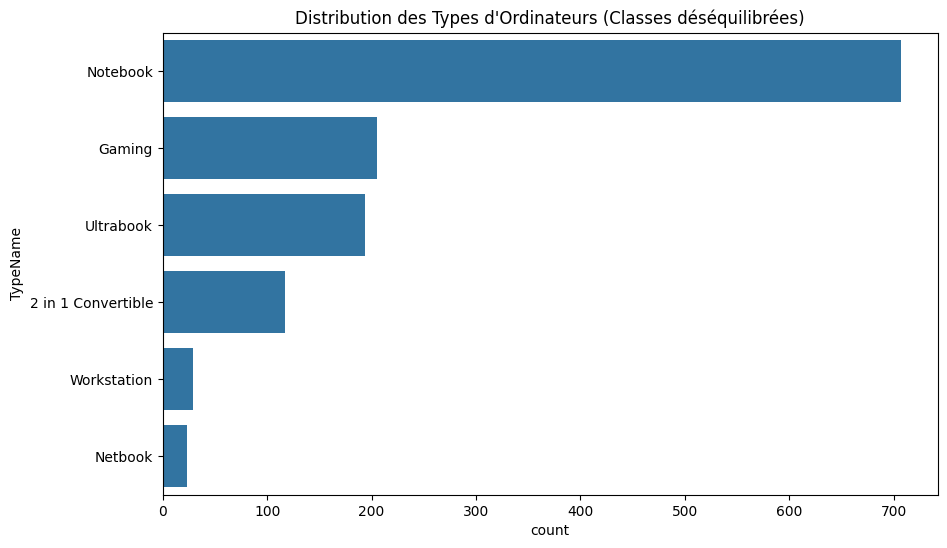

In [20]:
# Visualisation de la variable cible 'TypeName'
plt.figure(figsize=(10, 6))
sns.countplot(y=df_classif['TypeName'], order=df_classif['TypeName'].value_counts().index)
plt.title("Distribution des Types d'Ordinateurs (Classes déséquilibrées)")
plt.show()

In [21]:
# 1. Encodage de la Cible (TypeName)
# On transforme 'Gaming', 'Ultrabook'... en 0, 1, 2...
le = LabelEncoder()
df_classif['TypeName'] = le.fit_transform(df_classif['TypeName'])

# On garde le dictionnaire pour savoir à quoi correspond chaque chiffre
type_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print("Mapping des classes :", type_mapping)

# 2. Encodage des Variables Explicatives (Company, OS, CPU, GPU...)
# On utilise get_dummies pour créer des colonnes binaires (0 ou 1)
df_encoded = pd.get_dummies(df_classif, drop_first=True)

df_encoded.shape
display(df_encoded.head(3))

Mapping des classes : {np.int64(0): '2 in 1 Convertible', np.int64(1): 'Gaming', np.int64(2): 'Netbook', np.int64(3): 'Notebook', np.int64(4): 'Ultrabook', np.int64(5): 'Workstation'}


,TypeName,Ram,Weight,CPU_freq,PrimaryStorage,SecondaryStorage,PPI,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,Company_Fujitsu,Company_Google,Company_HP,Company_Huawei,Company_LG,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Microsoft,Company_Razer,Company_Samsung,Company_Toshiba,Company_Vero,Company_Xiaomi,OS_Chrome OS,OS_Linux,OS_Mac OS X,OS_No OS,OS_Windows 10,OS_Windows 10 S,OS_Windows 7,OS_macOS,Touchscreen_Yes,IPSpanel_Yes,RetinaDisplay_Yes,CPU_company_Intel,CPU_company_Samsung,CPU_model_A10-Series 9620P,CPU_model_A10-Series A10-9620P,CPU_model_A12-Series 9700P,CPU_model_A12-Series 9720P,CPU_model_A4-Series 7210,CPU_model_A6-Series 7310,CPU_model_A6-Series 9220,CPU_model_A6-Series A6-9220,CPU_model_A8-Series 7410,CPU_model_A9-Series 9410,CPU_model_A9-Series 9420,CPU_model_A9-Series A9-9420,CPU_model_Atom X5-Z8350,CPU_model_Atom Z8350,CPU_model_Atom x5-Z8300,CPU_model_Atom x5-Z8350,CPU_model_Atom x5-Z8550,CPU_model_Celeron Dual Core 3205U,CPU_model_Celeron Dual Core 3855U,CPU_model_Celeron Dual Core N3050,CPU_model_Celeron Dual Core N3060,CPU_model_Celeron Dual Core N3350,CPU_model_Celeron Quad Core N3160,CPU_model_Celeron Quad Core N3450,CPU_model_Celeron Quad Core N3710,CPU_model_Core M,CPU_model_Core M 6Y30,CPU_model_Core M 6Y54,CPU_model_Core M 6Y75,CPU_model_Core M 7Y30,CPU_model_Core M M3-6Y30,CPU_model_Core M M7-6Y75,CPU_model_Core M m3,CPU_model_Core M m3-7Y30,CPU_model_Core M m7-6Y75,CPU_model_Core i3 6006U,CPU_model_Core i3 6100U,CPU_model_Core i3 7100U,CPU_model_Core i3 7130U,CPU_model_Core i5,CPU_model_Core i5 6200U,CPU_model_Core i5 6260U,CPU_model_Core i5 6300HQ,CPU_model_Core i5 6300U,CPU_model_Core i5 6440HQ,CPU_model_Core i5 7200U,CPU_model_Core i5 7300HQ,CPU_model_Core i5 7300U,CPU_model_Core i5 7440HQ,CPU_model_Core i5 7500U,CPU_model_Core i5 7Y54,CPU_model_Core i5 7Y57,CPU_model_Core i5 8250U,CPU_model_Core i7,CPU_model_Core i7 6500U,CPU_model_Core i7 6560U,CPU_model_Core i7 6600U,CPU_model_Core i7 6700HQ,CPU_model_Core i7 6820HK,CPU_model_Core i7 6820HQ,CPU_model_Core i7 6920HQ,CPU_model_Core i7 7500U,CPU_model_Core i7 7560U,CPU_model_Core i7 7600U,CPU_model_Core i7 7660U,CPU_model_Core i7 7700HQ,CPU_model_Core i7 7820HK,CPU_model_Core i7 7820HQ,CPU_model_Core i7 7Y75,CPU_model_Core i7 8550U,CPU_model_Core i7 8650U,CPU_model_Cortex A72&A53,CPU_model_E-Series 6110,CPU_model_E-Series 7110,CPU_model_E-Series 9000,CPU_model_E-Series 9000e,CPU_model_E-Series E2-6110,CPU_model_E-Series E2-9000,CPU_model_E-Series E2-9000e,CPU_model_FX 8800P,CPU_model_FX 9830P,CPU_model_Pentium Dual Core 4405U,CPU_model_Pentium Dual Core 4405Y,CPU_model_Pentium Dual Core N4200,CPU_model_Pentium Quad Core N3700,CPU_model_Pentium Quad Core N3710,CPU_model_Pentium Quad Core N4200,CPU_model_Ryzen 1600,CPU_model_Ryzen 1700,CPU_model_Xeon E3-1505M V6,CPU_model_Xeon E3-1535M v5,CPU_model_Xeon E3-1535M v6,PrimaryStorageType_HDD,PrimaryStorageType_Hybrid,PrimaryStorageType_SSD,SecondaryStorageType_Hybrid,SecondaryStorageType_No,SecondaryStorageType_SSD,GPU_company_ARM,GPU_company_Intel,GPU_company_Nvidia,GPU_model_FirePro W4190M,GPU_model_FirePro W5130M,GPU_model_FirePro W6150M,GPU_model_GTX 980 SLI,GPU_model_GeForce 150MX,GPU_model_GeForce 920,GPU_model_GeForce 920M,GPU_model_GeForce 920MX,GPU_model_GeForce 920MX,GPU_model_GeForce 930M,GPU_model_GeForce 930MX,GPU_model_GeForce 930MX,GPU_model_GeForce 940M,GPU_model_GeForce 940MX,GPU_model_GeForce 960M,GPU_model_GeForce GT 940MX,GPU_model_GeForce GTX 1050,GPU_model_GeForce GTX 1050 Ti,GPU_model_GeForce GTX 1050M,GPU_model_GeForce GTX 1050Ti,GPU_model_GeForce GTX 1060,GPU_model_GeForce GTX 1070,GPU_model_GeForce GTX 1070M,GPU_model_GeForce GTX 1080,GPU_model_GeForce GTX 930MX,GPU_model_GeForce GTX 940M,GPU_model_GeForce GTX 940MX,GPU_model_GeForce GTX 950M,GPU_model_GeForce GTX 960,GPU_model_GeForce GTX 960<U+039C>,GPU_model_GeForce GTX 960M,GPU_model_GeForce GTX 965M,GPU_model_GeForce GTX 970M,GPU_model_GeForce GTX 980,GPU_model_GeForce GTX 980M,GPU_model_GeForce GTX105

In [22]:
X = df_encoded.drop(columns=['TypeName'])
y = df_encoded['TypeName']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Données d'entraînement : {X_train.shape}")
print(f"Données de test : {X_test.shape}")

Données d'entraînement : (1020, 247)
Données de test : (255, 247)


In [23]:
# Normalisation (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # On applique la même transformation au Test

# Application de SMOTE
# On génère des voisins artificiels pour équilibrer les classes (ex: créer plus de 'Workstations')
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("Distribution avant SMOTE :", y_train.value_counts().to_dict())
print("Distribution après SMOTE :", y_train_balanced.value_counts().to_dict())

Distribution avant SMOTE : {3: 568, 1: 161, 4: 160, 0: 89, 5: 23, 2: 19}
Distribution après SMOTE : {0: 568, 1: 568, 3: 568, 4: 568, 2: 568, 5: 568}


### 6. Modélisation et Comparaison

#### 6.1 Modèle de référence : K-Nearest Neighbors (KNN)
Nous commençons par tester un algorithme simple basé sur la distance (KNN). Les données ont été normalisées (`StandardScaler`) précédemment, ce qui est indispensable pour ce type de modèle.

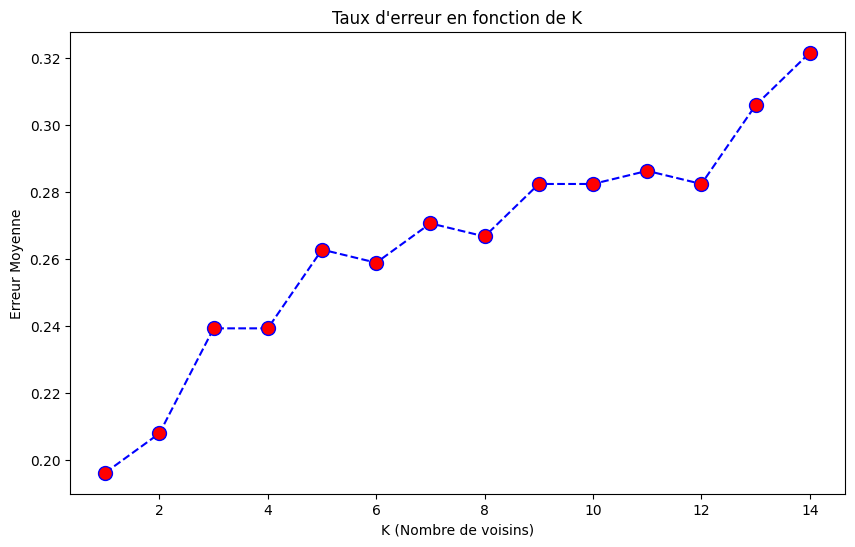

In [24]:
error_rate = []

for i in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_balanced, y_train_balanced)
    pred_i = knn.predict(X_test_scaled)

    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1, 15), error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title("Taux d'erreur en fonction de K")
plt.xlabel('K (Nombre de voisins)')
plt.ylabel('Erreur Moyenne')
plt.show()

 Précision globale : 80.39%

Rapport de Classification détaillé :

                    precision    recall  f1-score   support

2 in 1 Convertible       0.93      0.50      0.65        28
            Gaming       0.89      0.95      0.92        44
           Netbook       0.25      0.25      0.25         4
          Notebook       0.87      0.84      0.86       139
         Ultrabook       0.53      0.74      0.62        34
       Workstation       0.75      1.00      0.86         6

          accuracy                           0.80       255
         macro avg       0.71      0.71      0.69       255
      weighted avg       0.83      0.80      0.80       255



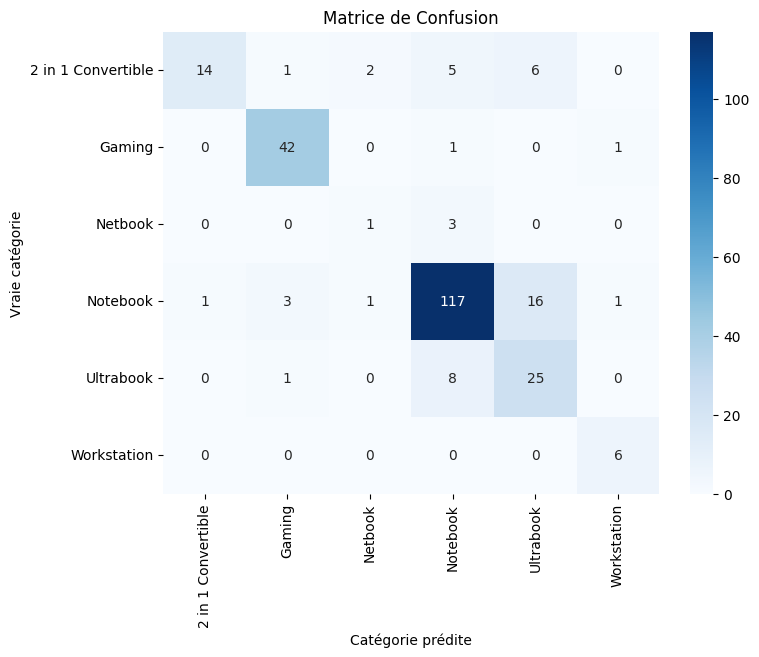

In [25]:
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(X_train_balanced, y_train_balanced)

y_pred = classifier.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f" Précision globale : {acc*100:.2f}%")
print("\nRapport de Classification détaillé :\n")
print(classification_report(y_test, y_pred, target_names=type_mapping.values()))

# Matrice de Confusion (Pour voir où il se trompe)
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=type_mapping.values(), yticklabels=type_mapping.values())
plt.title("Matrice de Confusion")
plt.ylabel('Vraie catégorie')
plt.xlabel('Catégorie prédite')
plt.show()

#### 6.2 Amélioration : Random Forest
Le score du KNN (~80%) est correct mais peut être amélioré. Les arbres de décision gèrent mieux les relations non-linéaires complexes et sont moins sensibles au bruit.
Nous testons donc un **Random Forest** pour tenter de dépasser cette performance.

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Entraînement (Random Forest)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

# Prédictions
y_pred_rf = rf_model.predict(X_test_scaled)
acc_rf = accuracy_score(y_test, y_pred_rf)

In [27]:
print(f" Score KNN : {acc:.2%}")
print(f" Score Random Forest  : {acc_rf:.2%}")

 Score KNN : 80.39%
 Score Random Forest  : 84.31%


In [28]:
# 4. Rapport détaillé
print("--- Résultats du Random Forest ---")
print(classification_report(y_test, y_pred_rf, target_names=type_mapping.values()))

--- Résultats du Random Forest ---
                    precision    recall  f1-score   support

2 in 1 Convertible       0.89      0.57      0.70        28
            Gaming       0.86      0.98      0.91        44
           Netbook       0.75      0.75      0.75         4
          Notebook       0.88      0.90      0.89       139
         Ultrabook       0.67      0.76      0.71        34
       Workstation       1.00      0.33      0.50         6

          accuracy                           0.84       255
         macro avg       0.84      0.72      0.74       255
      weighted avg       0.85      0.84      0.84       255



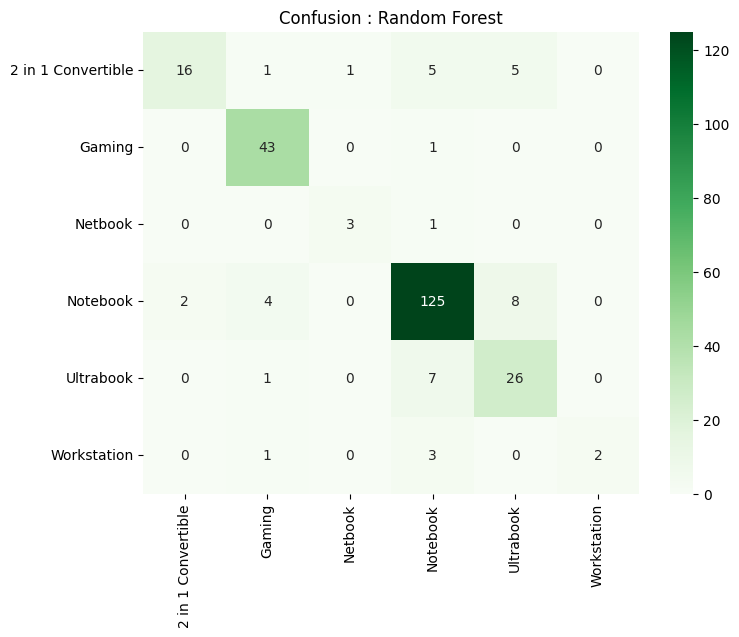

In [29]:
# Visualisation des erreurs
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens',
            xticklabels=type_mapping.values(), yticklabels=type_mapping.values())
plt.title("Confusion : Random Forest")
plt.show()

In [30]:
import pickle
import os

# Sauvegarde explicite du Random Forest
pickle.dump(rf_model, open('../models/rf_model.pkl', 'wb'))

# Sauvegarde des outils annexes (Scaler, Encodeur, Colonnes)
pickle.dump(scaler, open('../models/rf_scaler.pkl', 'wb'))
pickle.dump(le, open('../models/rf_label_encoder.pkl', 'wb'))
pickle.dump(list(X.columns), open('../models/rf_columns.pkl', 'wb'))